In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.profile_performance as profile_performance
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000

In [45]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/profile/config/E2F6/E2F6_training_paths.json"
num_tasks = 2
use_controls = True
model_class = profile_models.ProfilePredictorWithControls
noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/E2F6_keep1"
prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/E2F6_prior_keep1"

In [31]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/profile/config/SPI1/SPI1_training_paths.json"
num_tasks = 4
use_controls = True
model_class = profile_models.ProfilePredictorWithControls
noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_keep1"
prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_keep1"

In [5]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_DNase/profile/config/HepG2/HepG2_training_paths.json"
num_tasks = 2
use_controls = True
model_class = profile_models.ProfilePredictorWithoutControls
noprior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/HepG2"
prior_model_base_path = "/users/amtseng/att_priors/models/trained_models/profile_models/HepG2_prior"

In [46]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [33]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [34]:
def import_metrics_json(model_base_path, run_num):
    """
    Looks in {model_base_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(model_base_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [9]:
def get_model_paths(
    model_base_path, metric_name="val_prof_corr_losses",
    reduce_func=(lambda values: np.mean(values)), compare_func=(lambda x, y: x < y),
    print_found_values=True
):
    """
    Looks in `model_base_path` and for each run, returns the full path to
    the best epoch. By default, the best epoch in a run is determined by
    the lowest validation profile loss.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(model_base_path, run_num) for run_num in os.listdir(model_base_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    model_paths = []
    for run_num in sorted(metrics.keys(), key=lambda x: int(x)):
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            model_path = os.path.join(model_base_path, run_num, "model_ckpt_epoch_%d.pt" % best_epoch_in_run)
            model_paths.append(model_path)
            if print_found_values:
                print("\tRun %s, epoch %d: %6.2f" % (run_num, best_epoch_in_run, best_val_in_run))
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return model_paths
        

In [47]:
noprior_model_paths = get_model_paths(noprior_model_base_path)

	Run 1, epoch 10: 166.20
	Run 2, epoch 5: 168.17
	Run 3, epoch 9: 165.65
	Run 4, epoch 7: 165.09
	Run 5, epoch 8: 164.66
	Run 6, epoch 8: 168.10
	Run 7, epoch 3: 167.38
	Run 8, epoch 9: 166.45
	Run 9, epoch 6: 163.61
	Run 10, epoch 8: 165.28
	Run 11, epoch 8: 166.53
	Run 12, epoch 5: 163.70
	Run 13, epoch 10: 165.54
	Run 14, epoch 6: 164.89
	Run 15, epoch 6: 171.06
	Run 16, epoch 10: 164.77
	Run 17, epoch 5: 165.28
	Run 18, epoch 9: 166.38
	Run 19, epoch 7: 163.95
	Run 20, epoch 3: 165.60
	Run 21, epoch 9: 167.56
	Run 22, epoch 8: 168.49
	Run 23, epoch 4: 164.14
	Run 24, epoch 4: 166.25
	Run 25, epoch 6: 166.25
	Run 26, epoch 6: 164.44
	Run 27, epoch 7: 168.54
	Run 28, epoch 10: 166.54
	Run 29, epoch 4: 166.04
	Run 30, epoch 5: 163.62
	Run 31, epoch 4: 166.82
	Run 32, epoch 10: 166.23
	Run 33, epoch 10: 168.69
	Run 34, epoch 6: 166.65
	Run 35, epoch 5: 166.61
	Run 36, epoch 7: 165.17
	Run 37, epoch 6: 166.08
	Run 38, epoch 9: 166.89
	Run 39, epoch 4: 164.95
	Run 40, epoch 5: 165.28
	Ru

In [48]:
prior_model_paths = get_model_paths(prior_model_base_path)

	Run 1, epoch 6: 165.63
	Run 2, epoch 9: 164.51
	Run 3, epoch 6: 169.43
	Run 4, epoch 7: 164.62
	Run 5, epoch 9: 167.71
	Run 6, epoch 3: 167.41
	Run 7, epoch 6: 164.78
	Run 8, epoch 7: 165.98
	Run 9, epoch 6: 166.53
	Run 10, epoch 8: 166.47
	Run 11, epoch 4: 167.66
	Run 12, epoch 7: 166.50
	Run 13, epoch 7: 166.64
	Run 14, epoch 3: 166.40
	Run 15, epoch 10: 168.43
	Run 16, epoch 6: 164.55
	Run 17, epoch 6: 166.63
	Run 18, epoch 10: 162.91
	Run 19, epoch 10: 166.51
	Run 20, epoch 9: 165.19
	Run 21, epoch 9: 164.47
	Run 22, epoch 9: 164.37
	Run 23, epoch 9: 167.20
	Run 24, epoch 6: 164.11
	Run 25, epoch 10: 168.14
	Run 26, epoch 6: 168.14
	Run 27, epoch 10: 165.06
	Run 28, epoch 10: 165.30
	Run 29, epoch 10: 165.94
	Run 30, epoch 4: 164.59
	Run 31, epoch 5: 165.59
	Run 32, epoch 8: 166.15
	Run 33, epoch 9: 165.63
	Run 34, epoch 2: 166.56
	Run 35, epoch 6: 166.29
	Run 36, epoch 7: 165.20
	Run 37, epoch 5: 165.25
	Run 38, epoch 9: 165.21
	Run 39, epoch 9: 170.49
	Run 40, epoch 9: 167.60
	R

In [12]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [49]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [50]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

### Predicting profiles

In [15]:
def predict_coords(
    model, coords, fourier_att_prior_freq_limit=160,
    fourier_att_prior_freq_limit_softness=None, print_losses=True
):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset,
    the input gradients, and the loss values. The returned profiles are in terms
    of raw counts, and the returned counts are also raw. Returned values are all
    NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    if use_controls:
        true_profs = profiles[:, :num_tasks, :, :]
        cont_profs = profiles[:, num_tasks:, :, :]
    else:
        true_profs, cont_profs = profiles, None

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, 0, 20, 50,
            None, 1, 3, fourier_att_prior_freq_limit,
            fourier_att_prior_freq_limit_softness, False, input_grads, status
    )
    prof_loss, count_loss, att_loss = \
        prof_loss.item(), count_loss.item(), att_loss.item()
    if print_losses:
        print("Profile loss\tCounts loss\tPrior loss")
        print("%6.3f\t%6.3f\t%6.3f" % (prof_loss, count_loss, att_loss))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), \
        true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np, \
        prof_loss, count_loss, att_loss

### Compute consistency

In [51]:
# Pick a sample of 100 random coordinates
num_coords = 100
sample_coords = pos_coords_table[pos_coords_table[0].isin(["chr8", "chr10"])].sample(num_coords).values[:, :3]

In [17]:
def compute_gradients(model_paths, sample_coords, batch_size=128):
    """
    Given a list of paths to M models and a list of N coordinates, computes
    the input gradients over all models, returning an M x N x I x 4 array of
    gradient values and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_coords = len(model_paths), len(sample_coords)
    
    num_batches = int(np.ceil(num_coords / batch_size))
    
    all_input_grads = np.empty((num_models, num_coords, input_length, 4))
    all_one_hot_seqs = np.empty((num_coords, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
        for j in range(num_batches):
            batch_slice = slice(j * batch_size, (j + 1) * batch_size)
            coord_batch = sample_coords[batch_slice]
            _, _, _, _, one_hot_seqs, input_grads, _, _, _ = predict_coords(
                model, coord_batch, print_losses=False
            )
            all_input_grads[i, batch_slice] = input_grads
            if i == 0:
                all_one_hot_seqs[batch_slice] = one_hot_seqs
    return all_input_grads, all_one_hot_seqs

In [52]:
# Compute the gradients and 1-hot seqs
prior_grads, one_hot_seqs = compute_gradients(prior_model_paths, sample_coords)
noprior_grads, _ = compute_gradients(noprior_model_paths, sample_coords)

['chr8' 60660541 60660871]
Without priors:
---------------
Model 36


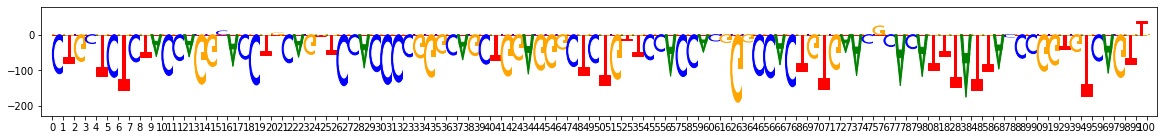

Model 31


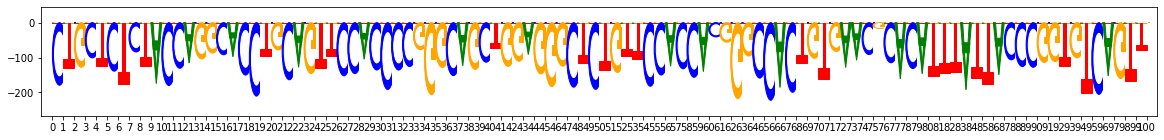

Model 44


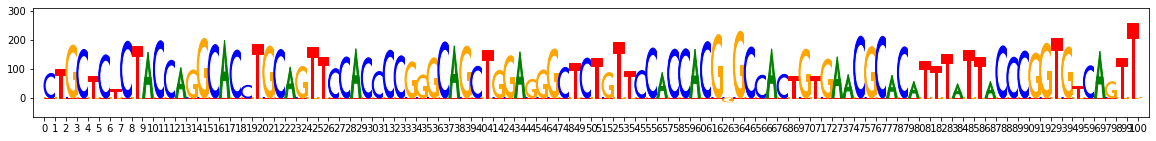

With priors:
------------
Model 21


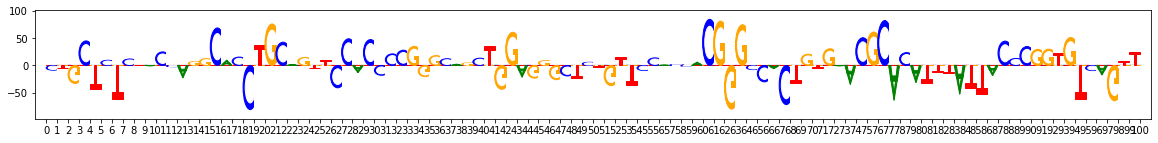

Model 4


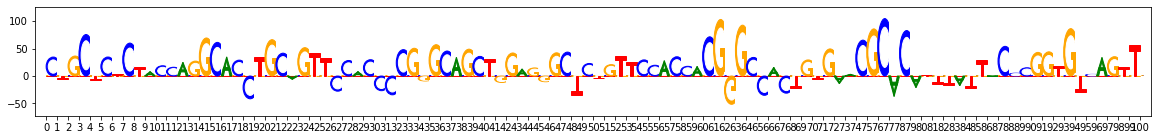

Model 40


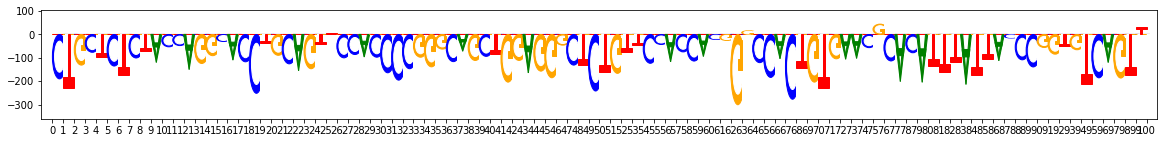

['chr10' 132354902 132355105]
Without priors:
---------------
Model 7


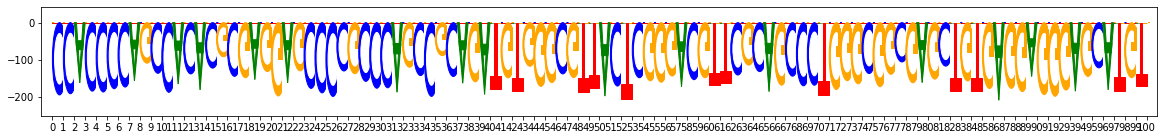

Model 5


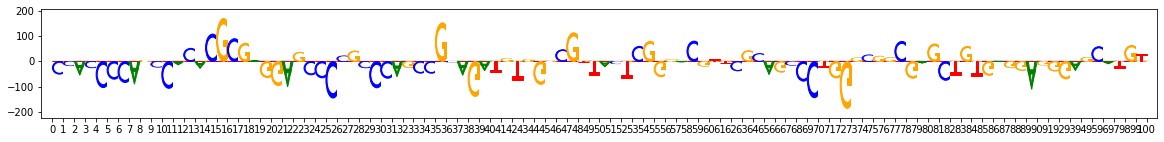

Model 49


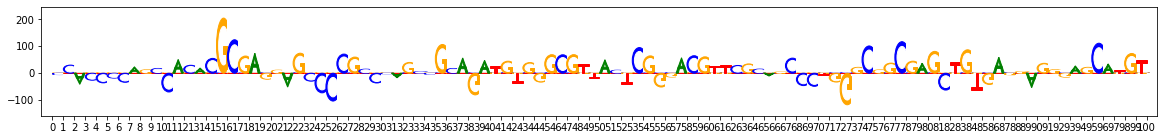

With priors:
------------
Model 2


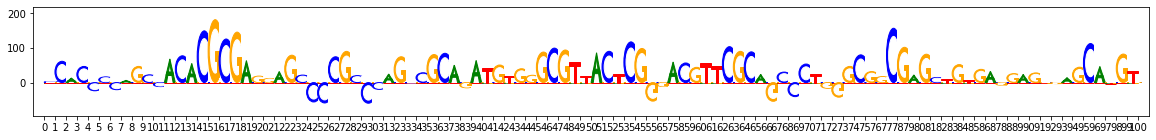

Model 9


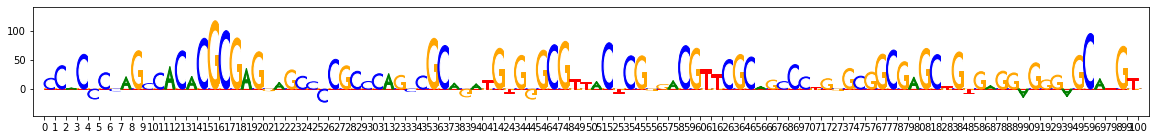

Model 49


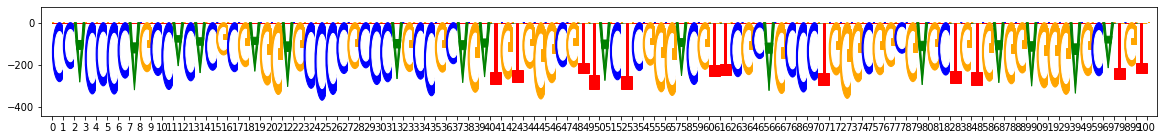

['chr10' 71888967 71889286]
Without priors:
---------------
Model 20


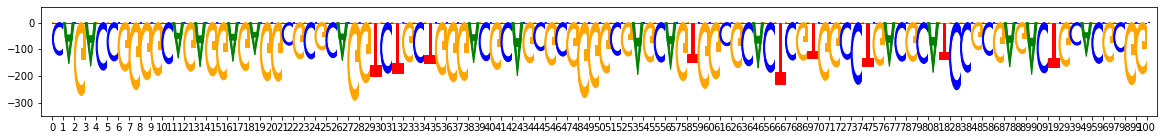

Model 1


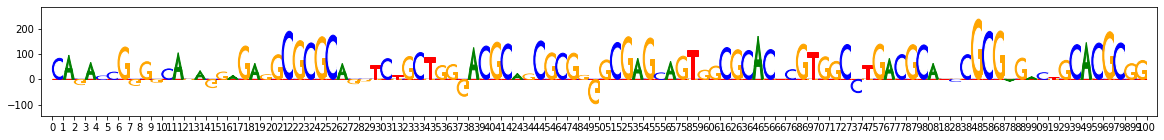

Model 35


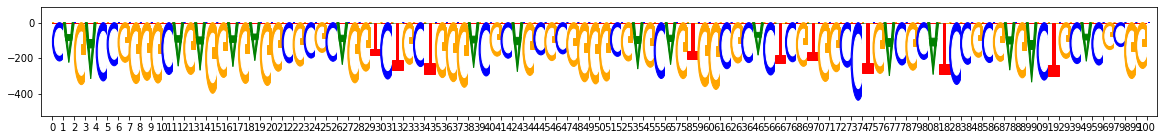

With priors:
------------
Model 43


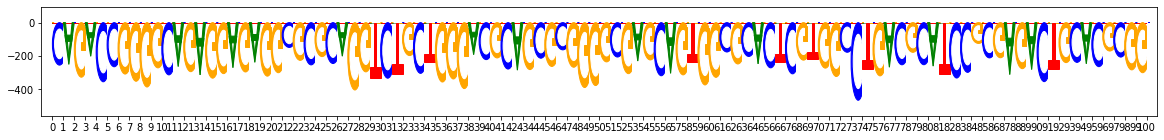

Model 32


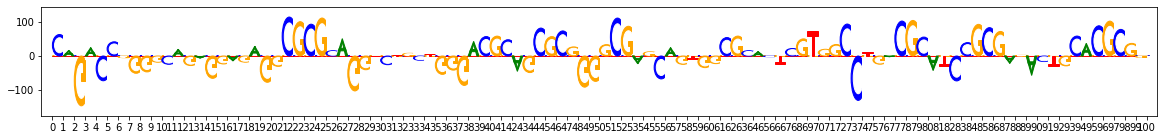

Model 39


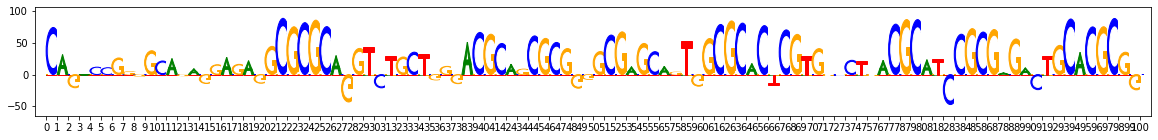

In [53]:
# Plot out a few examples over some different models
center_slice = slice(600, 700)
for i in np.random.choice(num_coords, size=3):
    print(sample_coords[i])
    print("=========================")
    print("Without priors:")
    print("---------------")
    for j in np.random.choice(len(noprior_model_paths), size=3):
        print("Model %d" % (j + 1))
        viz_sequence.plot_weights(noprior_grads[j, i, center_slice] * one_hot_seqs[i, center_slice])
    print("With priors:")
    print("------------")
    for j in np.random.choice(len(prior_model_paths), size=3):
        print("Model %d" % (j + 1))
        viz_sequence.plot_weights(prior_grads[j, i, center_slice] * one_hot_seqs[i, center_slice])

In [20]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [21]:
def cosine_sim(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a cosine similarity.
    """
    dot = np.sum(seq_1 * seq_2, axis=1)
    mag_1, mag_2 = np.sqrt(np.sum(seq_1 * seq_1, axis=1)), np.sqrt(np.sum(seq_2 * seq_2, axis=1))
    return np.sum(dot / (mag_1 * mag_2))

In [22]:
def compute_similarity_matrix(input_grads, sim_func=cont_jaccard):
    """
    Given the M x N x I x 4 input gradients returned by `compute_gradients`,
    computes an N x M x M similarity matrix of similarity across models (i.e.
    each coordinate gets a similarity matrix across different models).
    By defaults uses the continuous Jaccard similarity score
    """
    num_models, num_coords = input_grads.shape[0], input_grads.shape[1]
    
    sim_mats = np.empty((num_coords, num_models, num_models))
    for i in tqdm.notebook.trange(num_coords):
        for j in range(num_models):
            sim_mats[i, j, j] = 0
            for k in range(j):
                sim_score = sim_func(input_grads[j][i], input_grads[k][i])
                sim_mats[i, j, k] = sim_score
                sim_mats[i, k, j] = sim_score
    return sim_mats

In [54]:
prior_sim_matrix = compute_similarity_matrix(prior_grads, sim_func=cosine_sim)
noprior_sim_matrix = compute_similarity_matrix(noprior_grads, sim_func=cosine_sim)

Average similarity without priors: 377.591609
Average similarity with priors: 434.707663
Test of difference of means: t = 12.879738, p = 0.000000


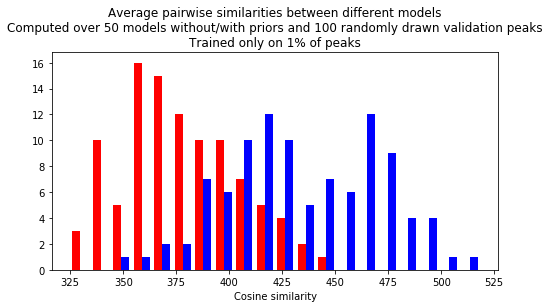

In [55]:
noprior_avg_sims, prior_avg_sims = [], []
bin_num = 20
for i in range(num_coords):
    noprior_avg_sims.append(np.nanmean(noprior_sim_matrix[i][np.tril_indices(len(noprior_model_paths), k=-1)]))
    prior_avg_sims.append(np.nanmean(prior_sim_matrix[i][np.tril_indices(len(prior_model_paths), k=-1)]))
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_avg_sims, prior_avg_sims],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    "Average pairwise similarities between different models" +
    "\nComputed over 50 models without/with priors and 100 randomly drawn validation peaks" +
    "\nTrained only on 1% of peaks"
)
plt.xlabel("Cosine similarity")

print("Average similarity without priors: %f" % np.mean(noprior_avg_sims))
print("Average similarity with priors: %f" % np.mean(prior_avg_sims))
t, p = scipy.stats.ttest_ind(prior_avg_sims, noprior_avg_sims)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))